In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Setting the High Level Parameters for the Notebook

In [3]:
time_budget = 60 # time budget for auto-ml in seconds (advisable at least 120)
verbose = 0 # verbosity of auto-ml
n_splits = 5 # cross-fitting and cross-validation splits
cfit = False
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
plot = True # whether to plot results
xfeat = 'inc' # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
# Formula for the BLP of CATE regression.
blp_formula = 'np.log(inc)' # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
hetero_feats = ['inc'] # list of subset of features to be used for CATE model or the string 'all' for everything
binary_y = False

## For semi-synthetic data generation
semi_synth = False # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

# Fetching the Data

The Criteo dataset can be downloaded from here:
https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/input
This file should be downloaded and stored in the same folder as the notebook with the name `criteo-uplift-v2.1.csv`.

The welfare dataset can be downloaded from here:
https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/ProcessedData/welfarenolabel3.csv
This file should be downloaded and stored in the same folder as the notebook with the name `welfarenolabel3.csv`. And is drawn from the analysis in this paper: [Green and Kern, 2012, Modeling Heterogeneous Treatment Effects in Survey Experiments with Bayesian Additive Regression Trees](https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/Green%20and%20Kern%20BART.pdf)

The 401k dataset is downloaded from the source by the code and no need to further download anything:
https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv

In [4]:
from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, y, groups = get_data()

In [5]:
if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')

In [6]:
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

# Data Analysis

We now have our data $X$, $D$, $y$, of controls, treatments and outcomes. In some datasets, we also have "groups", also known as "clusters". These are group ids, that define a group of samples that are believed to be correlated through unobesrved factors. For instance, in randomized experiments when a whole class is being treated and we have data at the student level, the students in a class constitute a cluster, as their outcome variables are most probably correlated. In such settings, it is helpful to account for the cluster correlations when calculating confidence intervals and when performing sample splitting for either cross-validation or for nuisance estimation.

We will be assuming throughout that conditional ignorability is satisfied if we control for all the variables $X$, i.e. the potential outcomes $Y(1), Y(0)$ satisfy
\begin{align}
Y(1), Y(0) ~\perp\hspace{-1em}\perp~D \mid X
\end{align}
Equivalently, we assume that the DAG the corresponds to our setting satisfies that $X$ is a valid adjustment set between $D$ and $Y$, i.e. it blocks all backdoor paths in the DAG.

In [7]:
X.describe()

,age,inc,fsize,educ,db,marr,male,twoearn,pira,nohs,hs,smcol,col,hown
count,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000
mean,41.034891,36462.224269,2.868361,13.192672,0.271202,0.603746,0.205949,0.380198,0.238678,0.127419,0.379477,0.247118,0.245986,0.635241
std,10.337014,22193.821846,1.541154,2.787505,0.444603,0.489143,0.404414,0.485460,0.426298,0.333459,0.485282,0.431358,0.430692,0.481387
min,25.000000,4080.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,19648.500000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,31473.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,48071.250000,4.000000,15.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,64.000000,118599.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


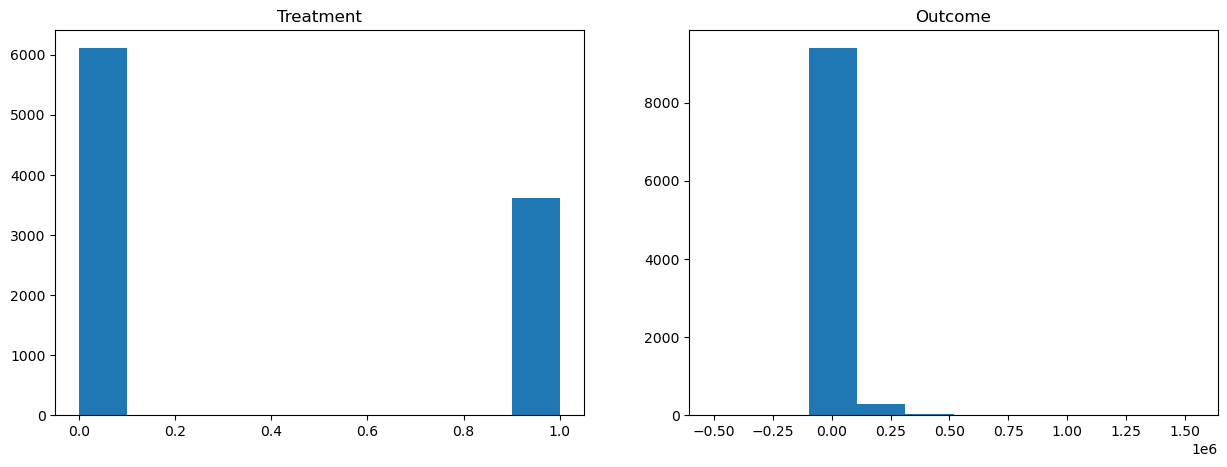

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

# Split Train and Validation and Test

The training data will be used to fit the various CATE models. The validation data will be used for scoring and selection of the best CATE model or best ensemble of CATE models. The test data will be used for testing and evaluation of the performance of the best chosen model. 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

if groups is None:
    X, Xval, D, Dval, y, yval = train_test_split(X, D, y, train_size=.6, shuffle=True, random_state=123)
    Xval, Xtest, Dval, Dtest, yval, ytest = train_test_split(Xval, Dval, yval, train_size=.5, shuffle=True, random_state=123)
    groupsval, groupstest = None, None
else:
    train, val = next(GroupShuffleSplit(n_splits=2, train_size=.6, random_state=123).split(X, y, groups=groups))
    X, Xval, D, Dval, y, yval = X.iloc[train], X.iloc[val], D[train], D[val], y[train], y[val]
    groups, groupsval = groups[train], groups[val]

    val, test = next(GroupShuffleSplit(n_splits=2, train_size=.5, random_state=123).split(Xval, yval, groups=groupsval))
    Xval, Xtest, Dval, Dtest, yval, ytest = Xval.iloc[val], Xval.iloc[test], Dval[val], Dval[test], yval[val], yval[test]
    groupsval, groupstest = groupsval[val], groupsval[test]

# Nuisance Model Selection

Using the training data we will select the best model for each of the nuisance models that arise in meta learner CATE approaches. They five models correspond to the following five predictive problems:
\begin{align}
\text{model_reg} ~\rightarrow~& g(d, x) := E[Y\mid D=d, X=x]\\
\text{model_y} ~\rightarrow~& q(x) := E[Y\mid X=x]\\
\text{model_t} ~\rightarrow~& p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model_reg_zero} ~\rightarrow~& g_0(x) := E[Y\mid D=0, X=x]\\
\text{model_reg_one} ~\rightarrow~& g_1(x) := E[Y\mid D=1, X=x]\\
\end{align}
We will select the best hyperparameters/model type for each predictive problem using cross-validation, where the splits are also stratified by the treatment (so that we have balanced split of the treatment groups across folds).

In [11]:
# if groups is None:
#     split_type = 'auto'
# else:
#     split_type = GroupKFold(n_splits=n_splits)
    
# # These function calls perform auto-ml hyperparameter tuning and return a "model class generator"
# # i.e. a function that whenever called returns an instance of an un-fitted model with the best hyper-parameters
# if binary_y:
#     model_reg = auto_clf(np.column_stack((D, X)), y, groups=groups, n_splits=n_splits, split_type=split_type, 
#                          verbose=verbose, time_budget=time_budget)
#     model_y = auto_clf(X, y, n_splits=n_splits, split_type=split_type, 
#                        verbose=verbose, time_budget=time_budget)
#     model_reg_zero = auto_clf(X[D==0], y[D==0], groups=groups, n_splits=n_splits, split_type=split_type, 
#                               verbose=verbose, time_budget=time_budget)
#     model_reg_one = auto_clf(X[D==1], y[D==1], groups=groups, n_splits=n_splits, split_type=split_type, 
#                              verbose=verbose, time_budget=time_budget)
# else:
#     model_reg = auto_reg(np.column_stack((D, X)), y, groups=groups, n_splits=n_splits, split_type=split_type, 
#                          verbose=verbose, time_budget=time_budget)
#     model_y = auto_reg(X, y, groups=groups, n_splits=n_splits, split_type=split_type, 
#                        verbose=verbose, time_budget=time_budget)
#     model_reg_zero = auto_reg(X[D==0], y[D==0], groups=groups, n_splits=n_splits, split_type=split_type, 
#                               verbose=verbose, time_budget=time_budget)
#     model_reg_one = auto_reg(X[D==1], y[D==1], groups=groups, n_splits=n_splits, split_type=split_type, 
#                              verbose=verbose, time_budget=time_budget)
# model_t = auto_clf(X, D, groups=groups, n_splits=n_splits, split_type=split_type, 
#                    verbose=verbose, time_budget=time_budget)

In [12]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val], verbose=False)
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        return self
    
    def predict(self, X):
        return self.predict_proba(X)[:, 1]

auto_reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20,
                             verbosity=0, random_state=123)
auto_clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0,
                              random_state=123)
def auto_weighted_reg(*args, **kwargs):
    return auto_reg

In [13]:
model_reg = auto_reg
model_y = auto_reg
model_reg_zero = auto_reg
model_reg_one = auto_reg
model_t = auto_clf

In [14]:
model_reg()

MyXGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=5,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=20, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=123, ...)

In [15]:
model_y()

MyXGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=5,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=20, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=123, ...)

In [16]:
model_t()

MyXGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=5,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.05, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=20, missing=nan, monotone_constraints=None,
                n_estimators=500, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=123, ...)

If you want to save or load these models from a previous run un-comment the following lines

In [17]:
# joblib.dump([model_reg(), model_y(), model_t(), model_reg_zero(), model_reg_one()], 'nuisance.jbl')

In [18]:
# mreg, my, mt, mreg_zero, mreg_one = joblib.load('nuisance.jbl')
# model_reg = lambda: clone(mreg)
# model_y = lambda: clone(my)
# model_t = lambda: clone(mt)
# model_reg_zero = lambda: clone(mreg_zero)
# model_reg_one = lambda: clone(mreg_one)

We now also evaluate the performance of the selected models in terms of R^2

In [19]:
if groups is None:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)
else:
    cv = GroupKFold(n_splits=n_splits)

In [20]:
score_reg = np.mean(cross_val_score(model_reg(), X, y, groups=groups, cv=cv, scoring='r2'))
print(f'model_reg: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_y(), X, y, groups=groups, cv=cv, scoring='r2'))
print(f'model_y: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_t(), X, D, groups=groups, cv=cv, scoring='r2'))
print(f'model_t: {score_reg:.3f}')
if groups is None:
    score_reg = np.mean(cross_val_score(model_reg_zero(), X[D==0], y[D==0], groups=None, cv=cv, scoring='r2'))
    print(f'model_reg_zero: {score_reg:.3f}')
    score_reg = np.mean(cross_val_score(model_reg_one(), X[D==1], y[D==1], groups=None, cv=cv, scoring='r2'))
    print(f'model_reg_one: {score_reg:.3f}')
else:
    score_reg = np.mean(cross_val_score(model_reg_zero(), X[D==0], y[D==0], groups=groups[D==0], cv=cv, scoring='r2'))
    print(f'model_reg_zero: {score_reg:.3f}')
    score_reg = np.mean(cross_val_score(model_reg_one(), X[D==1], y[D==1], groups=groups[D==1], cv=cv, scoring='r2'))
    print(f'model_reg_one: {score_reg:.3f}')

model_reg: 0.244
model_y: 0.239
model_t: 0.155
model_reg_zero: 0.203
model_reg_one: 0.217


# Nuisance Cross-Fitted Estimation and Prediction

After selecting the hyper-parameters for each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg_preds} \rightarrow~& \hat{g}(D_i, X_i) &
\text{reg_one_preds} \rightarrow~& \hat{g}(1, X_i) &
\text{reg_zero_preds} \rightarrow~& \hat{g}(0, X_i)\\
\text{reg_preds_t} \rightarrow~& \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i &
\text{reg_one_preds_t} \rightarrow~& \hat{g}_1(X_i) &
\text{reg_zero_preds_t} \rightarrow~& \hat{g}_0(X_i)\\
\text{res_preds} \rightarrow~& \hat{q}(X_i) &
\text{prop_preds} \rightarrow~& \hat{p}(X_i)
\end{align}

In [21]:
if cfit:
    if groups is None:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
        splits = list(cv.split(X, D))
    else:
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
        splits = list(cv.split(X, D, groups=groups))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg = model_reg().fit(DX[train], y[train])
    reg_preds[test] = reg.predict(DX[test])
    reg_one_preds[test] = reg.predict(np.column_stack([np.ones(len(test)), X.iloc[test]]))
    reg_zero_preds[test] = reg.predict(np.column_stack([np.zeros(len(test)), X.iloc[test]]))

    reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
    reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(model_y(), X, y, cv=splits)
prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

# ATE Estimation

Using plain OLS of $y\sim D, X$. For an RCT the coefficient associated with the treatment in the limit converges to the true ATE and provides correct inference for the true ATE.

In [22]:
dfX = X.copy()
dfX = dfX - dfX.mean(axis=0)
dfX['D'] = D
dfX['const'] = 1
if groups is None:
    display(OLS(y, dfX).fit(cov_type='HC1').summary())
else:
    display(OLS(y, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     77.40
Date:                Mon, 11 Sep 2023   Prob (F-statistic):          1.64e-210
Time:                        20:38:32   Log-Likelihood:            -1.1857e+05
No. Observations:                9716   AIC:                         2.372e+05
Df Residuals:                    9701   BIC:                         2.373e+05
Df Model:                          14                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age          626.6448     52.727     11.885      0.000     523.302     729.988
inc            0.6365      0.052     12.283      0.000       0.535       0.738
fsize       -859.5961    364.507     -2.358      0.018   -1574.017    -145.175
educ        -786.7039    704.124     -1.117      0.264   -2166.762     593.354
db         -3515.1160   1126.982     -3.119      0.002   -5723.961   -1306.271
marr        1226.5261   1625.680      0.754      0.451   -1959.748    4412.801
male         728.2425   1351.915      0.539      0.590   -1921.463    3377.948
twoearn    -1.353e+04   1697.278     -7.969      0.000   -1.69e+04   -1.02e+04
pira        2.989e+04   1612.547     18.534      0.000    2.67e+04     3.3e+04
nohs       -3629.1442   2543.747     -1.427      0.154   -8614.797    1356.509
hs          -574.7535    888.173     -0.647      0.518   -2315.540    1166.033
smcol       -170.3238   1071.711     -0.159      0.874   -2270.838    1930.191
col         4374.2214   2684.832      1.629      0.103    -887.953    9636.396
hown        2818.7887    785.759      3.587      0.000    1278.730    4358.847
D           7296.4810   1199.062      6.085      0.000    4946.362    9646.600
const       1.379e+04    669.665     20.593      0.000    1.25e+04    1.51e+04
==============================================================================
Omnibus:                    16845.127   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29196327.485
Skew:                          11.944   Prob(JB):                         0.00
Kurtosis:                     270.486   Cond. No.                     1.81e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 1.45e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Using plain OLS with the interactive model of $y\sim D, D*X, X$ (after de-meaning X). For an RCT the coefficient associated with the treatment in the limit converges to the true ATE and provides correct inference for the true ATE. Moreover, the interactions should be giving us dimensions of heterogeneity.

In [23]:
from formulaic import Formula
dfX = X.copy()
dfX = dfX - dfX.mean(axis=0)
dfX['D'] = D
dfX = Formula('D * (' + '+'.join(X.columns) + ')').get_model_matrix(dfX)
dfX['const'] = 1
if groups is None:
    display(OLS(y, dfX).fit(cov_type='HC1').summary())
else:
    display(OLS(y, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 28
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     64.72
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:38:33   Log-Likelihood:            -1.1853e+05
No. Observations:                9716   AIC:                         2.371e+05
Df Residuals:                    9688   BIC:                         2.373e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6540.6776    372.362     17.565      0.000    5810.861    7270.495
D           6144.0756   1072.524      5.729      0.000    4041.967    8246.184
age          476.9953     64.471      7.399      0.000     350.634     603.356
inc            0.4822      0.073      6.585      0.000       0.339       0.626
fsize       -625.8619    404.736     -1.546      0.122   -1419.130     167.406
educ       -1112.0559    929.635     -1.196      0.232   -2934.106     709.995
db         -4028.0699   1363.082     -2.955      0.003   -6699.662   -1356.478
marr         958.3784   1690.472      0.567      0.571   -2354.887    4271.644
male          82.3062   1419.864      0.058      0.954   -2700.576    2865.189
twoearn    -1.049e+04   1819.747     -5.767      0.000   -1.41e+04   -6927.437
pira        2.953e+04   2042.863     14.453      0.000    2.55e+04    3.35e+04
nohs       -5762.2599   3222.125     -1.788      0.074   -1.21e+04     552.989
hs          -896.7937   1119.829     -0.801      0.423   -3091.619    1298.032
smcol       -332.5582   1200.497     -0.277      0.782   -2685.489    2020.372
col         6991.6118   3433.535      2.036      0.042     262.006    1.37e+04
hown        1889.8013    804.265      2.350      0.019     313.470    3466.132
D:age        463.7444    110.231      4.207      0.000     247.695     679.794
D:inc          0.3300      0.103      3.211      0.001       0.129       0.531
D:fsize    -1021.4779    854.512     -1.195      0.232   -2696.290     653.334
D:educ      1183.1932   1273.892      0.929      0.353   -1313.589    3679.975
D:db        1961.9175   2327.704      0.843      0.399   -2600.299    6524.134
D:marr      2636.9906   4188.137      0.630      0.529   -5571.606    1.08e+04
D:male      2286.5143   3144.858      0.727      0.467   -3877.295    8450.323
D:twoearn  -7604.6030   3787.017     -2.008      0.045    -1.5e+04    -182.187
D:pira       263.1504   3274.968      0.080      0.936   -6155.669    6681.970
D:nohs      5506.3195   5058.360      1.089      0.276   -4407.884    1.54e+04
D:hs        1021.0280   1669.347      0.612      0.541   -2250.833    4292.889
D:smcol      474.1309   2360.843      0.201      0.841   -4153.037    5101.299
D:col      -7001.4784   4991.155     -1.403      0.161   -1.68e+04    2781.006
D:hown      4362.4688   1899.217      2.297      0.022     640.073    8084.865
const       6540.6776    372.362     17.565      0.000    5810.861    7270.495
==============================================================================
Omnibus:                    16933.937   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29965122.582
Skew:                          12.077   Prob(JB):                         0.00
Kurtosis:                     273.989   Cond. No.                     1.43e+18
==

Using the residual on residual regression, which should be giving us a correct estimate of the ATE in an RCT, and in observational settings a correct estimate of the ATE under a partially linear model (otherwise only a weighted average of the CATEs; weighted by the conditional variance of the treatment). In particular, we consider the residual outcome and the residual treatment, 
\begin{align}
\tilde{Y} :=~& Y - E[Y\mid X] \tag{yres}\\
\tilde{D} :=~& D - E[D\mid X] \tag{Dres}
\end{align}
and estimate the parameter in the BLP decomposition:
\begin{align}
\tilde{Y} =~& \theta \tilde{D} + \epsilon, & E[\epsilon \tilde{D}]=~& 0
\end{align}
equivalently, the parameter in the OLS $\tilde{Y}\sim \tilde{D}$. If we denote with $\theta(X):=E[Y(1)-Y(0)\mid X]$, then the method estimates the minimizer of the loss:
\begin{align}
\min_{\tau} E\left[\left(\theta(X) - \tau\right)^2 \, \text{Var}(D\mid X)\right]
\end{align}
For RCTs, we have $\text{Var}(D\mid X)=p$ (a constant) and hence $\tau$ corresponds to the ATE $E[\theta(X)]$.

In [24]:
yres = y - res_preds
Dres = D - prop_preds

if groups is None:
    display(OLS(yres, Dres).fit(cov_type='HC1').summary())
else:
    display(OLS(yres, Dres).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              57.63
Date:                Mon, 11 Sep 2023   Prob (F-statistic):                    3.46e-14
Time:                        20:38:34   Log-Likelihood:                     -1.1836e+05
No. Observations:                9716   AIC:                                  2.367e+05
Df Residuals:                    9715   BIC:                                  2.367e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8595.6537   1132.321      7.591      0.000    6376.345    1.08e+04
==============================================================================
Omnibus:                    17079.703   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30940436.773
Skew:                          12.303   Prob(JB):                         0.00
Kurtosis:                     278.358   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC1)
"""

Using the doubly robust method. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we estimate:
\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right]
\end{align}
This should be more efficient in the worst-case and should be returning a consistent estimate of the ATE even beyond RCTs and will also correctly account for any imbalances or violations of the randomization assumption in an RCT.

In [25]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)

if groups is None:
    display(OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='HC1').summary())
else:
    display(OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 11 Sep 2023   Prob (F-statistic):                nan
Time:                        20:38:34   Log-Likelihood:            -1.2519e+05
No. Observations:                9716   AIC:                         2.504e+05
Df Residuals:                    9715   BIC:                         2.504e+05
Df Model:                           0                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7671.2656    967.888      7.926      0.000    5774.239    9568.292
==============================================================================
Omnibus:                     7113.812   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33316764.188
Skew:                          -1.824   Prob(JB):                         0.00
Kurtosis:                     289.852   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

# Best Linear CATE Predictor and Simultaneous (Joint) Confidence Intervals

We can also use the doubly robust variables as pseudo-outcomes in an OLS regression, so as to estimate the best linear approximation of the true CATE. In an RCT, these should be similar to the coefficients recovered in a plain interactive OLS regression.

In [26]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)

dfX = X.copy()
dfX = dfX - dfX.mean(axis=0)
dfX['const'] = 1
if groups is None:
    lr = OLS(dr_preds, dfX).fit(cov_type='HC1')
    cov = lr.get_robustcov_results(cov_type='HC1')
else:
    lr = OLS(dr_preds, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups})
    cov = lr.get_robustcov_results(cov_type='cluster', groups=groups)
lr.summary()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.754
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           4.95e-06
Time:                        20:38:34   Log-Likelihood:            -1.2517e+05
No. Observations:                9716   AIC:                         2.504e+05
Df Residuals:                    9702   BIC:                         2.505e+05
Df Model:                          13                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age          215.1843     92.874      2.317      0.021      33.155     397.214
inc            0.2182      0.103      2.126      0.033       0.017       0.419
fsize       -364.9627    692.375     -0.527      0.598   -1721.993     992.068
educ        1183.3171   1140.410      1.038      0.299   -1051.845    3418.479
db          2016.1536   2204.110      0.915      0.360   -2303.823    6336.130
marr        -434.4176   3220.275     -0.135      0.893   -6746.041    5877.206
male        2863.8450   2414.991      1.186      0.236   -1869.450    7597.140
twoearn     -968.1246   3368.250     -0.287      0.774   -7569.774    5633.524
pira       -3164.0123   3096.281     -1.022      0.307   -9232.611    2904.586
nohs        6546.4806   4366.283      1.499      0.134   -2011.276    1.51e+04
hs           522.7923   1577.964      0.331      0.740   -2569.961    3615.545
smcol        -40.0261   2158.689     -0.019      0.985   -4270.978    4190.926
col        -7029.2468   4423.435     -1.589      0.112   -1.57e+04    1640.527
hown        3453.1251   1612.418      2.142      0.032     292.843    6613.407
const       7671.2656    966.607      7.936      0.000    5776.750    9565.781
==============================================================================
Omnibus:                     7445.095   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33967102.551
Skew:                          -2.021   Prob(JB):                         0.00
Kurtosis:                     292.634   Cond. No.                     1.99e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 1.21e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can also perform joint inference on all these parameters controlling the joint probability of failure of the confidence intervals by 95%.

In [27]:
V = cov.cov_params()
S = np.diag(np.diagonal(V)**(-1/2))
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), S @ V @ S, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(V)**(1/2)
lb = cov.params - critical * stderr
ub = cov.params + critical * stderr
jointsummary = pd.DataFrame({'coef': cov.params,
                             'std err': stderr,
                             'lb': lb,
                             'ub': ub,
                             'statsig': ['' if ((l <= 0) & (0 <= u)) else '**' for (l, u) in zip(lb, ub)]},
                            index=dfX.columns)
display(jointsummary)

,coef,std err,lb,ub,statsig
age,215.184349,92.873953,-55.638523,486.007220,
inc,0.218236,0.102647,-0.081086,0.517558,
fsize,-364.962743,692.375275,-2383.947116,1654.021629,
educ,1183.317111,1140.409690,-2142.147310,4508.781531,
db,2016.153603,2204.109997,-4411.088675,8443.395882,
marr,-434.417649,3220.275264,-9824.824369,8955.989072,
male,2863.845040,2414.990581,-4178.330526,9906.020606,
twoearn,-968.124633,3368.250175,-10790.030057,8853.780792,
pira,-3164.012349,3096.280506,-12192.847120,5864.822421,
nohs,6546.480626,4366.282640,-6185.713513,19278.674765,


We can also produce confidence intervals for the predictions of the CATE at particular points

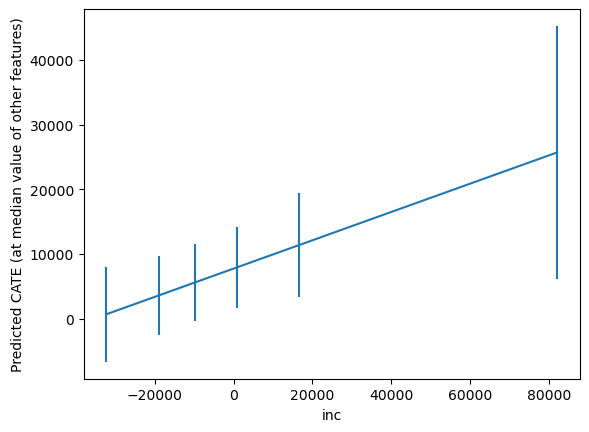

In [28]:
grid = np.unique(np.percentile(dfX[xfeat], np.arange(0, 110, 20)))

Zpd = pd.DataFrame(np.tile(np.median(dfX, axis=0, keepdims=True), (len(grid), 1)),
                    columns=dfX.columns)
Zpd[xfeat] = grid

pred_df = lr.get_prediction(Zpd).summary_frame()
preds, lb, ub = pred_df['mean'].values, pred_df['mean_ci_lower'].values, pred_df['mean_ci_upper'].values
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd[xfeat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(xfeat)
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

And even simultaneous inference on all these predictions that controls the joint failure probability of these confidence intervals to be at most 95%

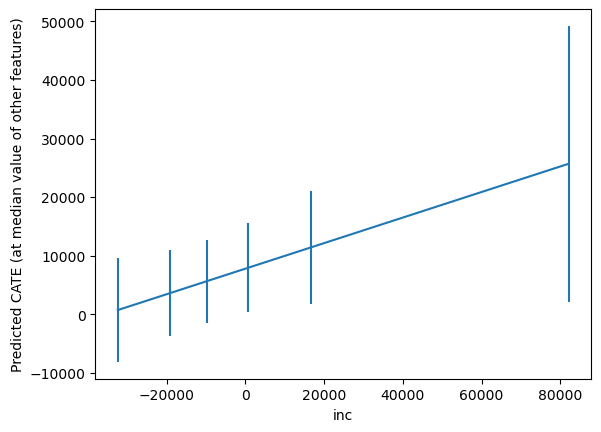

In [29]:
predsV = Zpd.values @ V @ Zpd.values.T
predsS = np.diag(np.diagonal(predsV)**(-1/2))
epsilon = np.random.multivariate_normal(np.zeros(predsV.shape[0]), predsS @ predsV @ predsS, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(predsV)**(1/2)
lb = preds - critical * stderr
ub = preds + critical * stderr

plt.errorbar(Zpd[xfeat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(xfeat)
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

# CATE Model Estimation with Meta-Learners

We specify which indices of the X variables we want to use for heterogeneity. Let's denote these subset of variables with $Z$

In [30]:
if hetero_feats == 'all':
    hetero_feats = X.columns
Z, Zval, Ztest = X[hetero_feats], Xval[hetero_feats], Xtest[hetero_feats]

We specify a generic automl approach for training the final CATE model

In [31]:
model_final_fn = lambda Z, y: auto_reg(Z, y, groups=groups,
                                       n_splits=n_splits, split_type=split_type, 
                                       verbose=verbose, time_budget=time_budget)

In [32]:
model_final_fn = lambda Z, y: auto_reg

### Single Learner (S-Learner)

The S-Learner simply trains a model to predict:
\begin{align}
\hat{g}(1, X_i) - \hat{g}(0, X_i) \sim Z_i
\end{align}

In [33]:
# slearner
slearner_best = model_final_fn(Z, reg_one_preds - reg_zero_preds)
slearner = slearner_best().fit(Z, reg_one_preds - reg_zero_preds)
slearner_cates = slearner.predict(Z)

### Two Learner (T-Learner)

The T-Learner simply trains a model to predict:
\begin{align}
\hat{g}_1(X_i) - \hat{g}_0(X_i) \sim Z_i
\end{align}

In [34]:
# tlearner
tlearner_best = model_final_fn(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner = tlearner_best().fit(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner_cates = tlearner.predict(Z)

### Cross Learner (X-Learner)

The X-Learner simply trains a two treatment effect models using all the variables $X$:
\begin{align}
\hat{\tau}_1: Y_i - \hat{g}_0(X_i) \sim X_i \\
\hat{\tau}_0: \hat{g}_1(X_i) - Y_i \sim X_i
\end{align}
And then for each target sample $X_i$ we select a mixture based on the propensity. 
If $D=1$ is more probable, then we use more heavily $\hat{\tau}_0$, since that uses the model $\hat{g}_1$ which was trained on more data similar to $X_i$ (as indicated by the propensity). Similarly, if $D=0$ is more probably we put more weight on $\hat{\tau}_1$. 
\begin{align}
\hat{\tau}(X_i) = \hat{p}(X_i) \hat{\tau}_0(X_i) + (1 - \hat{p}(X_i)) \hat{\tau}_1(X_i)
\tag{xtarget}
\end{align}
Finally, to learn a CATE model that only depends on $Z$, we predict the CATEs $\hat{\tau}$ from $Z$:
\begin{align}
\hat{\tau}(X_i) \sim Z_i
\end{align}

In [35]:
# xlearner
tau1_preds = y[D==1] - reg_zero_preds_t[D==1]
tau0_preds = reg_one_preds_t[D==0] - y[D==0]
tau1 = model_final_fn(X[D==1], tau1_preds)().fit(X[D==1], tau1_preds)
tau0 = model_final_fn(X[D==0], tau0_preds)().fit(X[D==0], tau0_preds)
xtarget = prop_preds * tau0.predict(X) + (1 - prop_preds) * tau1.predict(X)
xlearner = model_final_fn(Z, xtarget)().fit(Z, xtarget)
xlearner_cates = xlearner.predict(Z)

### Doubly Robust Learner (DR-Learner)

The DR-Learner (in particular, the variant based on the T-Learner) adds a de-biasing correction to the T-Learner using the propensity. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we train a CATE model by predicting these variables from $Z_i$:
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) \sim Z_i
\end{align}
For stability we clip the co-variance that appears in the denominator at some value $c$ bounded away from zero, i.e.
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\min\{c, \hat{p}(X_i) (1-\hat{p}(X_i))\}} 
\tag{dr_preds}
\end{align}

In [36]:
# drlearner
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
drlearner_best = model_final_fn(Z, dr_preds)
drlearner = drlearner_best().fit(Z, dr_preds)
drlearner_cates = drlearner.predict(Z)

### Residual Learner (R-Learner)

The R-Learner uses the fact that if the true CATE model 
$$\theta(X)=E[Y(1)-Y(0)\mid X]$$
only depends on the subset of variables $Z$, then we can write:
\begin{align}
Y =~& \tau(Z) D + b(X) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
This then implies that we can also write:
\begin{align}
Y - E[Y\mid X] =~& \tau(Z) (D - E[D|X]) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Hence, if we define the residual outcome and the residual treatment, 
\begin{align}
\tilde{Y} :=~& Y - E[Y\mid X] \tag{yres}\\
\tilde{D} :=~& D - E[D\mid X] \tag{Dres}
\end{align}
then we have:
\begin{align}
\tilde{Y} =~& \tau(Z) \tilde{D} + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Thus we can estimate the CATE by predicting $\tilde{Y}$ from $\tilde{D}, Z$ with a separable model of the form $\tau(Z) \tilde{D}$. This also implies that $\tau$ is the minimizer of the square loss:
\begin{align}
E\left[ \left(\tilde{Y} - \tau(Z) \tilde{D}\right)^2 \right]
\end{align}
This loss can also be re-written as a sample-weighted regression loss:
\begin{align}
E\left[ \tilde{D}^2 \left(\tilde{Y}/\tilde{D} - \tau(Z) \right)^2 \right]
\end{align}
We are predicting $\tilde{Y}/\tilde{D}$ form $Z$, using sample weights $\tilde{D}^2$.

If the true CATE $\theta(X)$ did not only depend on $Z$, but on the bigger set of covariates $X$, then this method estimates the best projection of the CATE $\theta(X)$ on the space of functions of $Z$, albeit, in a weighted manner, weighted by the variance of the treatment. More formally, the method estimates the minimizer of the following loss:
\begin{align}
\min_{\tau} E\left[\left(\theta(X) - \tau(Z)\right)^2 \, \text{Var}(D\mid X)\right]
\end{align}

In [37]:
# rlearner
yres = y - res_preds
Dres = D - prop_preds
Dres = np.clip(Dres, .001, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -.001) * (Dres < 0)

rlearner_fn = auto_weighted_reg(Z, yres / Dres, sample_weight=Dres**2, groups=groups,
                                n_splits=n_splits, verbose=verbose, time_budget=time_budget)
rlearner = rlearner_fn().fit(Z, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(Z)

## Constant Effect DR-Learner

We also add a heavily regularized CATE model that predicts the ATE using the doubly robust pseudo outcomes.

In [38]:
drlearner_const = make_pipeline(PolynomialFeatures(degree=0, include_bias=True), 
                                LinearRegression(fit_intercept=False)).fit(Z, dr_preds)
drlearner_const_cates = drlearner_const.predict(Z)

# Causal Score Estimation and Definition

We want to be able to select among all these different meta learners. For this reason we will use scoring functions that can evaluate the performance of an arbitrary CATE function and is not tailored to any particular methodology. This way we can evaluate all methods using the same score on the validation set and select the best among the methods, or ensemble the methods using this scoring metric. We will describe two such meta scores, the `R-score` and the `DR-score`.

## The Doubly Robust Score (DR-Score)

The doubly robust score calculates in a cross-fitting manner, using only the validation set, the doubly robust proxy variables $Y_i^{DR}(g,p)$, where $g,p$ are fitted in the validation set in the cross-fitting manner (or if the validation set is small, we can use the training set to estimate the nuisance models). Then for any candidate CATE model $\hat{\tau}$, the DR-score is simply the R^2 in the regression predicting $Y_i^{DR}(g,p)$ using $Z$, i.e.
\begin{align}
\text{DRscore}(\hat{\tau}) := 1 - \frac{E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{\text{Var}\left(Y^{DR}(g,p)\right)}
\end{align}
This can also be interpreted as normalizing by the best constant CATE model, since in this case the best constant CATE model is simply $\tau^*=E_n[Y^{DR}(g,p)]$ and therefore:
\begin{align}
\text{DRscore}(\hat{\tau}) = 1 - \frac{E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{E_n\left[\left(Y^{DR}(g,p) - \tau^*\right)^2\right]}
\end{align}

In [39]:
# def calculate_dr_outcomes(Xtrain, Dtrain, ytrain, groupstrain, X, D, y, groups):
#     if groups is None:
#         cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
#         splits = list(cv.split(X, D))
#     else:
#         cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
#         splits = list(cv.split(X, D, groups=groups))

#     n = X.shape[0]
#     reg_preds_t = np.zeros(n)
#     reg_zero_preds_t = np.zeros(n)
#     reg_one_preds_t = np.zeros(n)

#     for train, test in splits:
#         reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
#         reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
#         reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
#         reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
#         reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

#     prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

#     dr = reg_one_preds_t - reg_zero_preds_t
#     reisz = (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
#     dr += (y - reg_preds_t) * reisz

#     return dr

def calculate_dr_outcomes(Xtrain, Dtrain, ytrain, groupstrain, Xval, Dval, yval, groupsval):

    reg_zero = model_reg_zero().fit(Xtrain[Dtrain==0], ytrain[Dtrain==0])
    reg_one = model_reg_one().fit(Xtrain[Dtrain==1], ytrain[Dtrain==1])
    reg_zero_preds_t = reg_zero.predict(Xval)
    reg_one_preds_t = reg_one.predict(Xval)
    reg_preds_t = reg_zero_preds_t * (1 - Dval) + reg_one_preds_t * Dval
    prop_preds = model_t().fit(Xtrain, Dtrain).predict(Xval)

    dr = reg_one_preds_t - reg_zero_preds_t
    reisz = (Dval - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
    dr += (yval - reg_preds_t) * reisz

    return dr

dr_val = calculate_dr_outcomes(X, D, y, groups, Xval, Dval, yval, groupsval)

overall_ate_val_dr = np.mean(dr_val)

def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return drscore_b - drscore_t 

def drscore_delta(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    stderr = np.std((dr_val - overall_ate_val_dr)**2 - (dr_val - cate_preds)**2) / np.sqrt(cate_preds.shape[0])
    return drscore_b - drscore_t, stderr

# Score CATE Models

We first chose one of the scorers and we score all the CATE models.

In [40]:
scorer = drscore
score_name = 'DRscore'
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner', 'drlearner_const']
models = [slearner, tlearner, xlearner, drlearner, rlearner, drlearner_const]

In [41]:
scores = [scorer(model.predict(Zval)) for model in models]
print([f'{name}: {score:.4f}' for name, score in zip(names, scores)])

['slearner: 9411584.0000', 'tlearner: 87277568.0000', 'xlearner: 57651200.0000', 'drlearner: 94812160.0000', 'rlearner: 59520000.0000', 'drlearner_const: -2049.2822']


In [42]:
for name, model in zip(names, models):
    score = drscore_delta(model.predict(Zval))
    print(f'{name}: {score[0]:.4f} ({score[1]:.4f}) '
          f'[{score[0] - 1.96 * score[1]:.4f}, {score[0] + 1.96 * score[1]:.4f}]')

slearner: 9411584.0000 (2487747.4952) [4535598.9094, 14287569.0906]
tlearner: 87277568.0000 (39725591.0702) [9415409.5024, 165139726.4976]
xlearner: 57651200.0000 (30761017.5717) [-2640394.4405, 117942794.4405]
drlearner: 94812160.0000 (61496941.5275) [-25721845.3940, 215346165.3940]
rlearner: 59520000.0000 (19944284.8580) [20429201.6783, 98610798.3217]
drlearner_const: -2049.2822 (77906.5590) [-154746.1378, 150647.5735]


# Plotting CATE

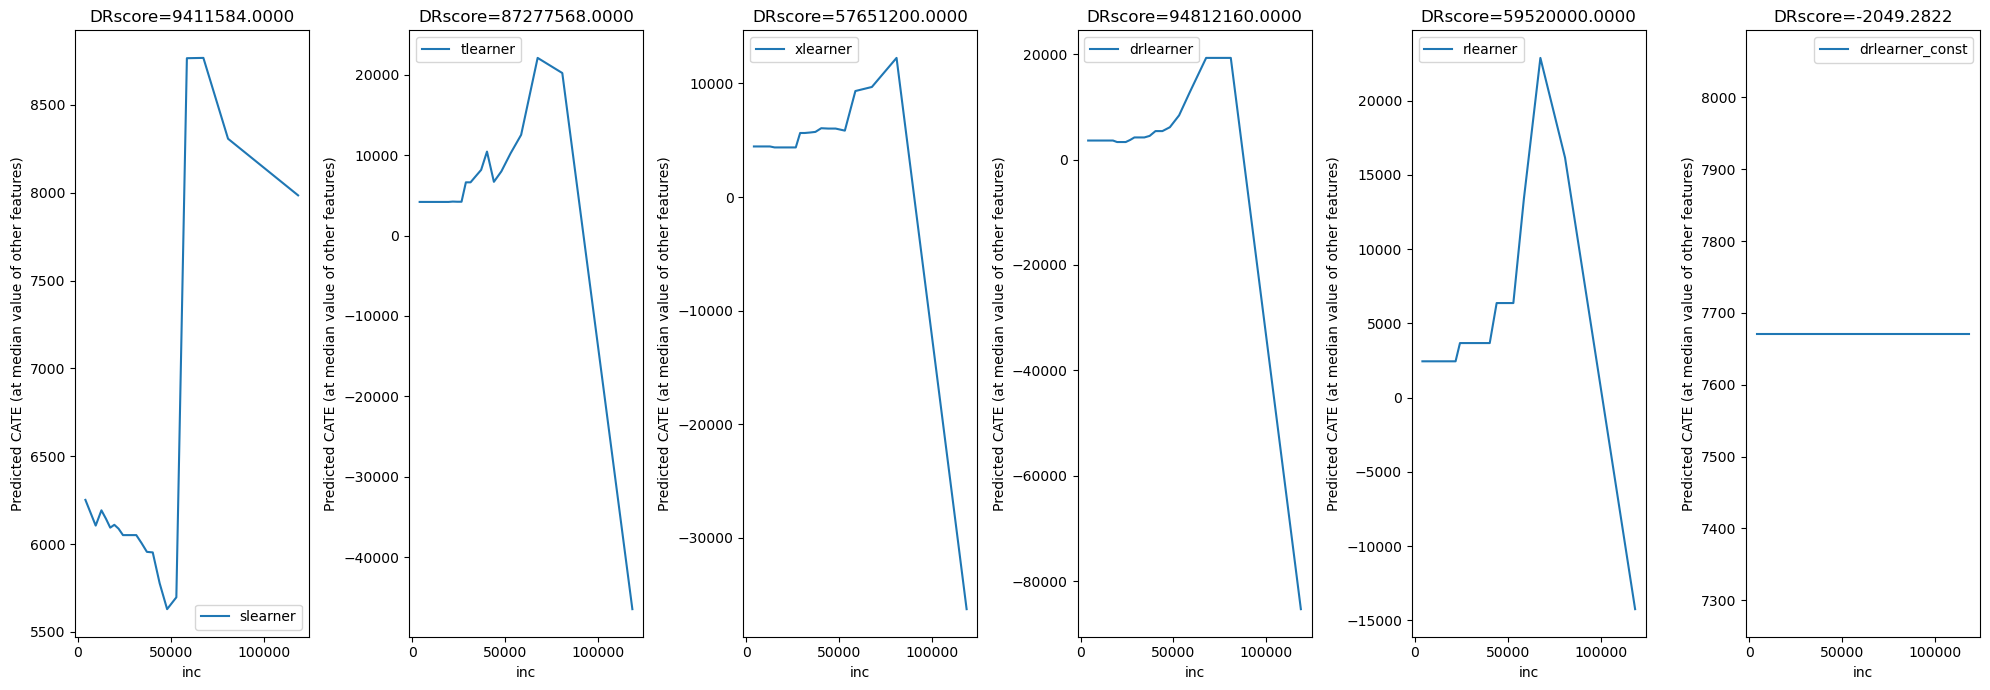

In [43]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                        columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(20, 7))
    for it, (name, model, score) in enumerate(zip(names, models, scores)):
        plt.subplot(1, len(models), it + 1)
        preds = model.predict(Xpd[hetero_feats])
        plt.plot(Xpd[xfeat], preds, label=name)
        if semi_synth:
            plt.plot(Xpd[xfeat], true_cate(Xpd), label='True')
            plt.title(f'{score_name}={score:.4f}, True RMSE={rmse(true_cate(X), model.predict(Z)):.5f}')
        else:
            plt.title(f'{score_name}={score:.4f}')
        plt.legend()
        plt.xlabel(xfeat)
        plt.ylabel('Predicted CATE (at median value of other features)')
    plt.tight_layout()
    plt.show()

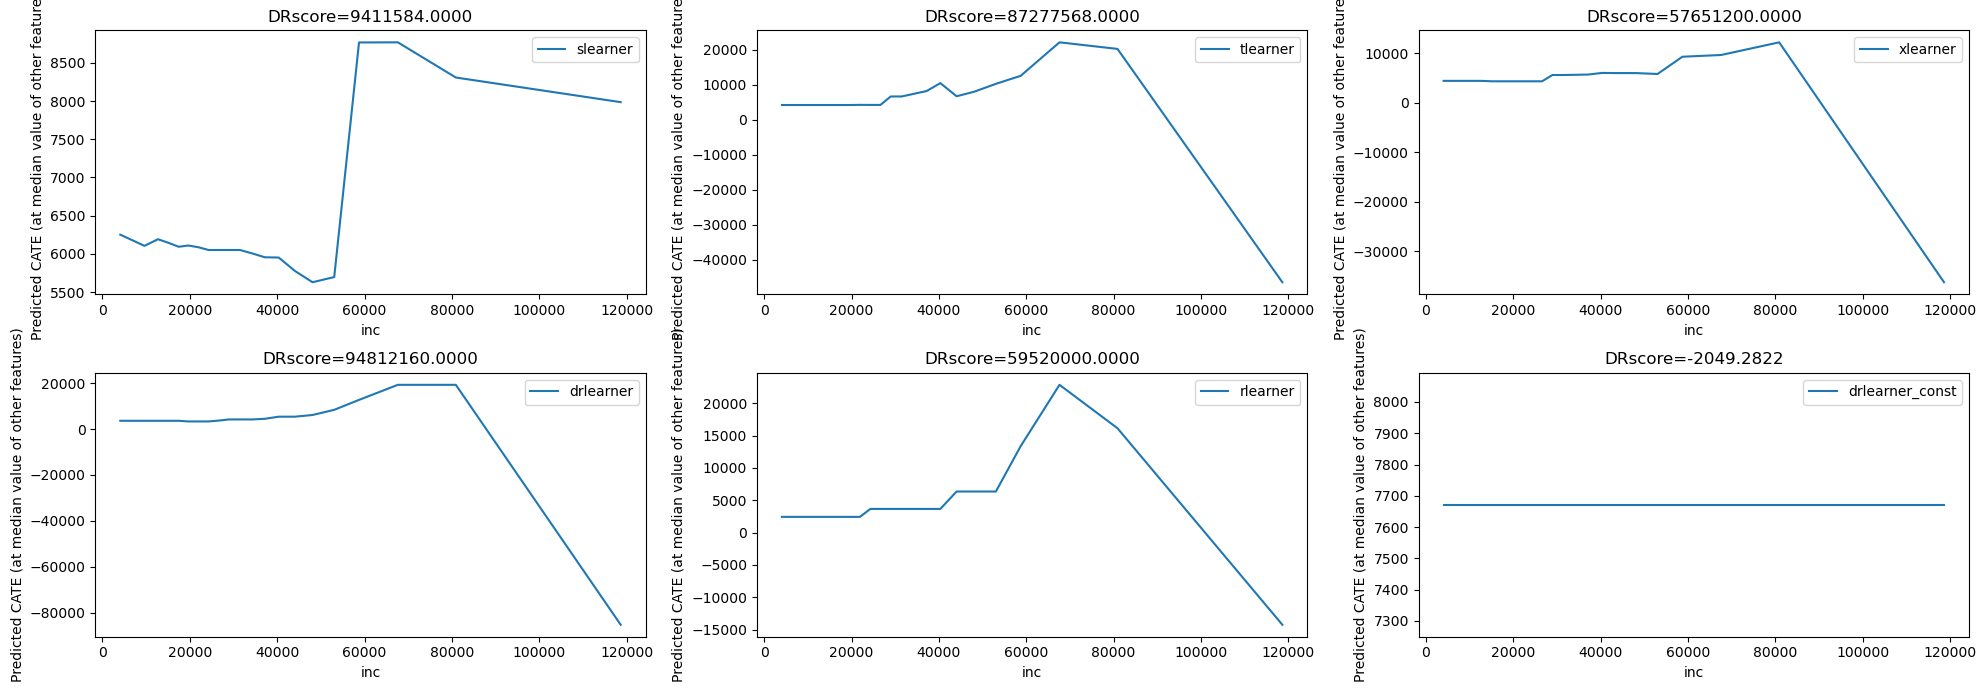

In [44]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                        columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(20, 7))
    for it, (name, model, score) in enumerate(zip(names, models, scores)):
        plt.subplot(2, len(models)//2, it + 1)
        preds = model.predict(Xpd[hetero_feats])
        plt.plot(Xpd[xfeat], preds, label=name)
        if semi_synth:
            plt.plot(Xpd[xfeat], true_cate(Xpd), label='True')
            plt.title(f'{score_name}={score:.4f}, True RMSE={rmse(true_cate(X), model.predict(Z)):.5f}')
        else:
            plt.title(f'{score_name}={score:.4f}')
        plt.legend()
        plt.xlabel(xfeat)
        plt.ylabel('Predicted CATE (at median value of other features)')
    plt.tight_layout()
    plt.show()

# Causal Model Selection and Ensembling

We can also use these scores to create an ensemble CATE model of the different methods based on the score performance. We want to create a new CATE model $\tau_E$ that is a weighted linear combination of all the cate models, i.e.
\begin{align}
\tau_E(Z) = \bar{\tau} + \sum_{m=1}^M w_m \tau_m(Z)
\end{align}
The weights $w_m$ should be increasing with the score of each CATE model $\tau_m$. Note that it can very well be that the score of the best ensemble is smaller than the score of the best single model, i.e. $\text{Score}(\tau_E) \geq \max_{m} \text{Score}(\tau_m)$. One way to achieve that in a smooth manner to avoid overfitting to the performance measure is to choose weights proportional to $\exp(\eta s_m)$, where $s_m$ is the score of CATE model $\tau_m$. When $\eta=0$ this will return uniform weights over all models and when $\eta\to \infty$, this will return the model with the best score. The "temperature" hyper-parameter $\eta$, can be chosen so that the ensemble achieves the smallest score.

In [45]:
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
    
    def __init__(self, names, models, weights, intercept=0):
        self.names = names
        self.models = models
        self.weights = weights
        self.intercept = intercept
    
    def predict(self, X):
        wcate = np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)
        return self.intercept + wcate

In [46]:
eta_grid = np.logspace(-5, 5, 10)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * np.array(scores))
    ensemble = Ensemble(names, models, weights)
    ens[eta] = (ensemble, scorer(ensemble.predict(Zval)))

score_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= score_best:
        score_best = ens[eta][1]
        eta_best = eta

softmax_ensemble = ens[eta_best][0]
softmax_ensemble

Ensemble(models=[MyXGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, early_stopping_rounds=5,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=0.05, max_bin=None,...
                                missing=nan, monotone_constraints=None,
                                n_estimators=500, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=123, ...),
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(degree=0)),
                                 ('linearregression',
                                  LinearRegression(fit_intercept=False))])],
         names=['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner',
                'drlearner_const'],
         weights=array([0., 0., 0., 1., 0., 0.]))

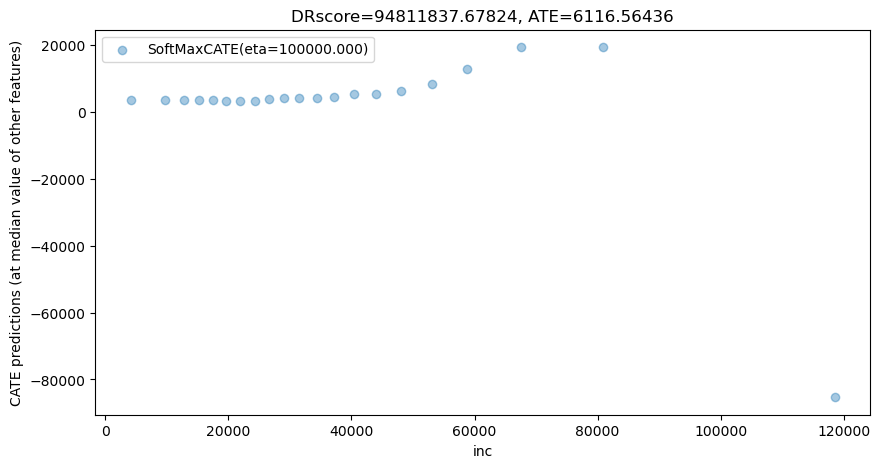

In [47]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                        columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(10, 5))
    plt.scatter(Xpd[xfeat], softmax_ensemble.predict(Xpd[hetero_feats]),
                label=f'SoftMaxCATE(eta={eta_best:.3f})', alpha=.4)
    if semi_synth:
        plt.scatter(Xpd[xfeat], true_cate(Xpd), label='True')
        plt.title(f'{score_name}={scorer(softmax_ensemble.predict(Zval)):.5f}, '
                  f'True RMSE={rmse(true_cate(X), ens[eta_best][0].predict(Z)):.5f}')
    else:
        plt.title(f'{score_name}={scorer(softmax_ensemble.predict(Zval)):.5f}, '
                  f'ATE={np.mean(ens[eta_best][0].predict(Z)):.5f}')
    plt.xlabel(xfeat)
    plt.ylabel('CATE predictions (at median value of other features)')
    plt.legend()
    plt.show()

Alternatively we could have also performed Stacking by fitting a (potentially $\ell_1$-penalized) linear model to minimize the corresponding loss. For the case of the DR score this boils down to a penalized linear regression, predicting $Y^{DR}(g,p)$ on the validation set, using $\tau_1(Z),\ldots, \tau_M(Z)$ as technical regressors:
\begin{align}
\min_{w} E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \sum_{m=1}^M w_m \tilde{\tau}_m(Z)\right)^2 \right] + \lambda \text{Penalty}(w)
\end{align}
where $\bar{\tau}$ is the ATE estimate based on the doubly robust method on the training data and $\tilde{\tau}_m(Z)$ are the de-meaned CATE predictions from each model, i.e. $\tilde{\tau}_m(Z) = \tau_m(Z) - E_n[\tau_m(Z)]$ where the empirical expectation is over the training data.

This way we are constructing an ensemble of the CATE on top of the best constant prediction on the training data and penalizing only the offset from this ATE. We avoid adding a coefficient around $\bar{\tau}$ to avoid introducing noise to the ATE estimate, due to the smaller sample in the validation set.

For the case of the R-loss, this boils down to a penalized linear regression, predicting $\tilde{Y}$ on the validation set, using $\tau_1(Z)\tilde{D}, \ldots, \tau_M(Z)\tilde{D}$ as technical regressors:
\begin{align}
\min_{w} E_n\left[ \left(\tilde{Y} - \bar{\tau} \tilde{D} - \sum_{m=1}^M w_m \tilde{\tau}_m(Z) \tilde{D}\right)^2 \right] + \lambda \text{Penalty}(w)
\end{align}
where the penalty can also be chosen within the validation set via cross-validation or based on theoretical specifications (e.g. for the Lasso).

In [48]:
from sklearn.linear_model import RidgeCV

F = np.array([m.predict(Zval) for m in models]).T
meansF = np.mean(F, axis=0)
F = F - meansF
# One of LassoCV(fit_intercept=False) or ElasticNetCV(fit_intercept=False) or
# or LinearRegression(fit_intercept=False) or LassoCV(positive=True, fit_intercept=False)
stacker = LassoCV(fit_intercept=False)
if score_name == 'DRscore':
    stacker.fit(F, dr_val - np.mean(dr_preds))
    intercept = np.mean(dr_preds) - meansF @ stacker.coef_
    stack_ensemble = Ensemble(names, models, stacker.coef_, intercept)
elif score_name == 'Rscore':
    # we will avoid penalizing the intercept of the CATE by multiplying the constant 1
    # by a large number; equivalently this divides the penalty for that parameter by that number
    stacker.fit(F * Dres_val.reshape(-1, 1), yres_val - np.mean(dr_preds) * Dres_val)
    intercept = np.mean(dr_preds) - meansF @ stacker.coef_
    stack_ensemble = Ensemble(names, models, stacker.coef_, intercept)

stack_ensemble

Ensemble(intercept=-202.17999500464794,
         models=[MyXGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, early_stopping_rounds=5,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                le...
                                n_estimators=500, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=123, ...),
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(degree=0)),
                                 ('linearregression',
                                  LinearRegression(fit_intercept=False))])],
         names=['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner',
                'drlearner_const'],
         weights=array([ 0.        ,  0.3802417 ,  0.        ,  0.79985913,  0.        ,
       -0.        ]))

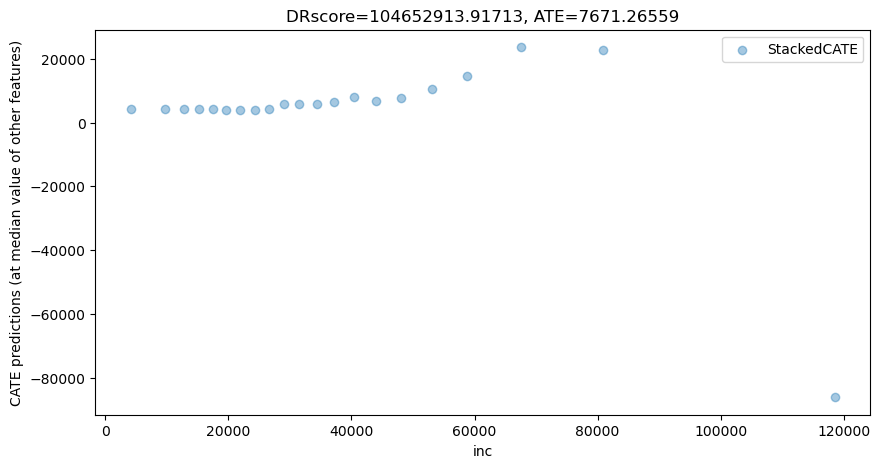

In [49]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                        columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(10, 5))
    plt.scatter(Xpd[xfeat], stack_ensemble.predict(Xpd[hetero_feats]),
                label=f'StackedCATE', alpha=.4)
    if semi_synth:
        plt.scatter(Xpd[xfeat], true_cate(Xpd), label='True')
        plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
                  f'True RMSE={rmse(true_cate(X), stack_ensemble.predict(Z)):.5f}')
    else:
        plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
                  f'ATE={np.mean(stack_ensemble.predict(Z)):.5f}')
    plt.xlabel(xfeat)
    plt.ylabel('CATE predictions (at median value of other features)')
    plt.legend()
    plt.show()

In [50]:
def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss

def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K)/K, jac=grad_q, bounds=[(0, 1)]*K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-12)
    return res.x

def qagg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.2, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)

In [51]:
F = np.array([m.predict(Zval) for m in models]).T
stack_ensemble = Ensemble(names, models, qagg(F, dr_val), 0)

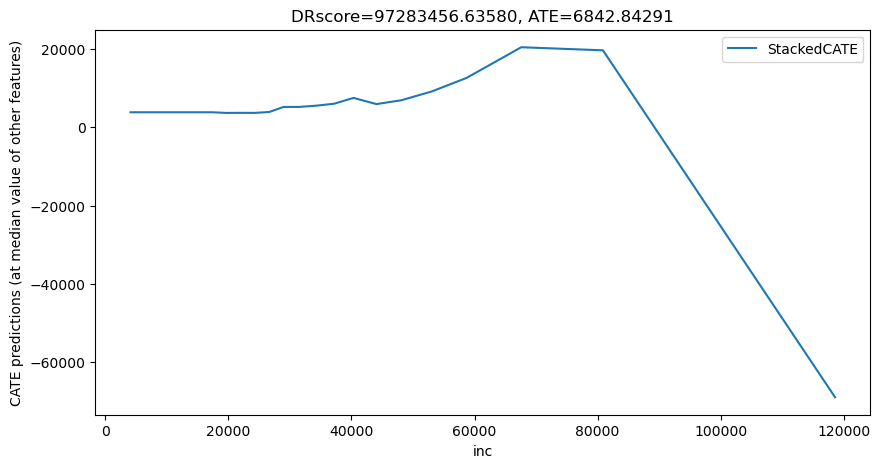

In [52]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                        columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(10, 5))
    plt.plot(Xpd[xfeat], stack_ensemble.predict(Xpd[hetero_feats]),
                label=f'StackedCATE')
    if semi_synth:
        plt.plot(Xpd[xfeat], true_cate(Xpd), '--', label='True')
        plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
                  f'True RMSE={rmse(true_cate(X), stack_ensemble.predict(Z)):.5f}')
    else:
        plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
                  f'ATE={np.mean(stack_ensemble.predict(Z)):.5f}')
    plt.xlabel(xfeat)
    plt.ylabel('CATE predictions (at median value of other features)')
    plt.legend()
    plt.show()

We use one of these ensembles as our final best model

In [53]:
overall_best = stack_ensemble
# overall_best = softmax_ensemble

# Validation Tests on Test Data

Now that we have a selected a winning CATE model (or ensemble), we can run a set of hypothesis tests and other diagnostic metrics on the test set, to see if the model really picked up some dimensions of effect heterogeneity and satisfies some self-conistency checks.

### Hypothesis Test Based on Doubly Robust Best-Linear Predictor of CATE using model of CATE

If we calculate the doubly robust pseudo outcomes $Y^{DR}(g,p)$ on the test set, using cross-fitting to estimate the models $g,p$, then we know that if the model of the CATE $\hat{\tau}$ is good, then the best linear predictor of the true CATE using $(1, \hat{\tau}(Z))$ as features should have a statistically significant coefficient on the feature associated with the CATE model. In fact, in an ideal world it should have a coefficient of $1$. Thus we can run such a significance test to measure whether the CATE model $\tau_m$ has picked up anything signal that is correlated with the true CATE. Note that if $\theta(X)$ is the true CATE $E[Y(1)-Y(0)\mid X]$, then the coefficient associated with $\hat{\tau}$ in this regression can be interpreted as identifying the quantity:
\begin{align}
\beta_1 := \frac{\text{Cov}(\theta(X), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))} = \frac{\text{Cov}(Y(1)-Y(0), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))}
\end{align}

In [54]:
dr_test = calculate_dr_outcomes(X, D, y, groups, Xtest, Dtest, ytest, groupstest)
cate_test = overall_best.predict(Ztest)

In [55]:
OLS(dr_test, np.stack((np.ones(len(dr_test)), cate_test), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     113.3
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           2.61e-26
Time:                        20:38:49   Log-Likelihood:            -1.2522e+05
No. Observations:                9716   AIC:                         2.504e+05
Df Residuals:                    9714   BIC:                         2.505e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1972.3768   1330.674     -1.482      0.138   -4580.774     636.021
x1             1.4158      0.133     10.644      0.000       1.155       1.676
==============================================================================
Omnibus:                     6826.056   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33538574.476
Skew:                          -1.653   Prob(JB):                         0.00
Kurtosis:                     290.810   Cond. No.                     1.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Validation Based on Calibration

We can measure whether each group defined by the quartile levels of CATE predictions is consistent with the out-of-sample Group ATE (GATE) for the corresponding group based on the doubly robust GATE estimate. (standard errors here ignore cluster/group correlations)

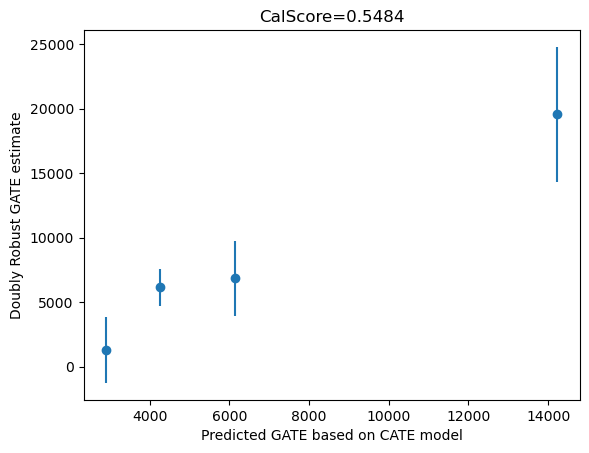

In [56]:
cate_val = overall_best.predict(Zval)
qs = np.percentile(cate_val, np.arange(0, 101, 25))

gate, gate_std, group_prob = np.zeros(len(qs) - 1), np.zeros(len(qs) - 1), np.zeros(len(qs) - 1)
predicted_gate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    # samples in the [q[it], q[it+1]) quantile group of predicted CATEs
    inds = (qs[it] <= cate_test) & (cate_test <= qs[it + 1]) 
    gate[it] = np.mean(dr_test[inds]) # DR estimate of group average treatment effect (GATE)
    gate_std[it] = np.std(dr_test[inds])/np.sqrt(np.sum(inds)) # standard error of GATE
    group_prob[it] = np.mean(inds) # probability mass of group
    predicted_gate[it] = np.mean(cate_test[inds]) # GATE as calculated from CATE model

# weighted average calibration error of cate model
cal = np.sum(group_prob * np.abs(gate - predicted_gate))
# weighted average calibration error of a constant cate model
calbase = np.sum(group_prob * np.abs(gate - np.mean(dr_test)))
# calibration score
calscore = 1 - cal/calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_gate, gate, yerr=1.96*gate_std, fmt='o')
plt.xlabel('Predicted GATE based on CATE model')
plt.ylabel('Doubly Robust GATE estimate')
plt.show()

We can also try to interpret what are the differences of characteristics between the top and bottom CATE groups; if we find that they have statistically significantly different GATEs. We can do that by either reporting the mean values of the covariates in the two groups or building some interpretable classification model that distinguishes between the two groups.

In [57]:
group1 = (qs[0] <= cate_test) & (cate_test < qs[1]) 
group2 = (qs[-2] <= cate_test) & (cate_test < qs[-1])
Ztest1 = Ztest[group1]
Ztest2 = Ztest[group2]

In [58]:
df = pd.DataFrame({'group1 means': np.mean(Ztest1, axis=0), 
                   'group1 s.e.': np.std(Ztest1, axis=0) / np.sqrt(Ztest1.shape[0]),
                   'group2 means': np.mean(Ztest2, axis=0),
                   'group2 s.e.': np.std(Ztest2, axis=0) / np.sqrt(Ztest2.shape[0]),
                   'group1 means - group2 means': np.mean(Ztest1, axis=0) - np.mean(Ztest2, axis=0),
                   'diff s.e.': (np.std(Ztest1, axis=0) / np.sqrt(Ztest1.shape[0]) 
                                 + np.std(Ztest2, axis=0) / np.sqrt(Ztest2.shape[0]))})
df

,group1 means,group1 s.e.,group2 means,group2 s.e.,group1 means - group2 means,diff s.e.
inc,24991.35082,378.21366,63064.616134,337.592278,-38073.265314,715.805937


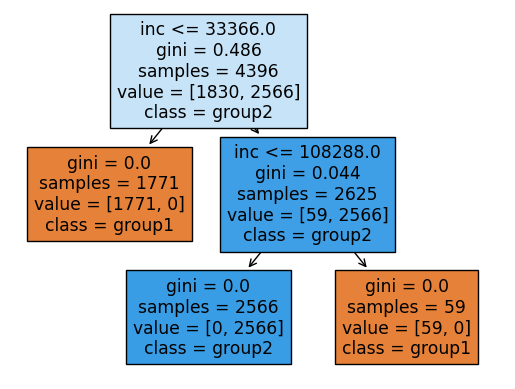

In [59]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(pd.concat((Ztest1, Ztest2)),
         np.concatenate((np.zeros(len(Ztest1)), np.ones(len(Ztest2)))))
plot_tree(tree, filled=True, feature_names=Ztest1.columns, class_names=['group1', 'group2'])
plt.show()

### Validation Based on Uplift Curves

These curves are related to "prioritization" or "stratification" implications of the CATE model. What if we target to treat a $q$-percentage of the population. Then if we trust and follow the CATE model, then we should be offering the treatment to the parts of the population that the CATE model predicts have a CATE larger than the $1-q$-th percentile of the CATE distribution as produced by the CATE.

In this case, we might care about the group average treatment effect of the group of people that are treated under such a prioritization rule and how that compares with the overall average treatment effect. Ideally, the group average treatment effect should be larger than the overall average treatment effect if the prioritization rule is correct.

Thus if we have a rough estimate $\hat{\mu}(q)$ of the $1-q$-quantile $\mu(q)$ of the CATE predictions distribution we can calculate:
\begin{align}
\tau(q) =~& E[Y(1) - Y(0) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\\
=~& E\left[(Y(1) - Y(0)) \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right] - E[Y(1) - Y(0)]
~=~ \text{Cov}\left(Y(1) - Y(0), \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right)
\end{align}
We can get such good quantile estimates out-of-sample, by looking at the $1-q$-the empirical quantile of the cate predictions on a sample other than the one that we are using to calculate $\tau(q)$. For instance, we can use the training/validation samples but not the test samples. This gives us a set of thresholds $\hat{\mu}(q_1), \ldots, \hat{\mu}(q_m)$ that are good approximations of the quantile of the predicted CATE distribution. If we target to treat every person with CATE greater than $\hat{\mu}(q_t)$ we should expect roughly $q_t$ fraction of the population to be treated.

This quantity is identified by replacing the individual effects with the doubly robust pseudo-outcomes:
\begin{align}
\tau(q) =~& E\left[Y^{DR}(g,p) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)\right] - E\left[Y^{DR}(g,p)\right]
~=~ \text{Cov}\left(Y^{DR}(g,p), \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right)
\end{align}

We can then plot the curve $\tau(q)$, understand the Area Under the Curve:
\begin{align}
AUTOC := \int_0^1 \tau(q) dq
\end{align}
and run tests whether that area is positive or that there is any positive point in the curve. These are tests that indicate that the CATE model detected heterogeneity with statistical significance. Moreover, the larger the Area Under the Curve, the better the CATE model is at treatment prioritization. (standard errors here ignore cluster/group correlations)

In [60]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0])) # influence function representation of the TOC at each quantile
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    toc[it]= np.mean(dr_test[inds]) - ate # tau(q) := E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    # influence function for the tau(q); it is a standard influence function of a "covariance"
    toc_psi[it, :] = (dr_test - ate) * (inds / group_prob - 1) - toc[it]
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n) # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds * n / np.sum(inds) - 1))

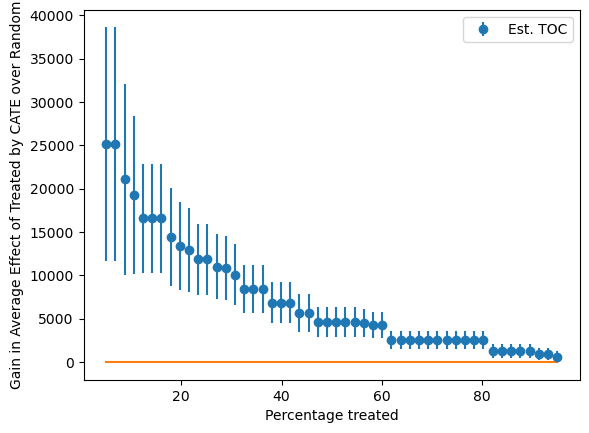

In [61]:
plt.errorbar(100 - ugrid, toc, yerr=1.96*toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

#### Uniform Confidence Band with Multiplier Bootstrap

In fact the "1.96" is wrong if we want the confidence intervals to hold simultaneoulsy for the whole curve. To have such "simultaneous coverage" guarantees we need to calculate a larger "critical value" than 1.96. We can calculate the appropriate such constant using the multiplier bootstrap, which tries to estimate the maximum deviation around the mean as a multiple of the standard deviation for each point. 

In [62]:
# For computational reasons if dataset is too large, we should not be constructing
# an n_samples x n_bootstrap_samples matrix of multipliers due to memory issues;
# even though constructing such a matrix avoids a for loop in python, which is always advised.
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (toc_psi / toc_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (toc_psi / toc_std.reshape(-1, 1)) @ w / n

max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)

2.696930420043139


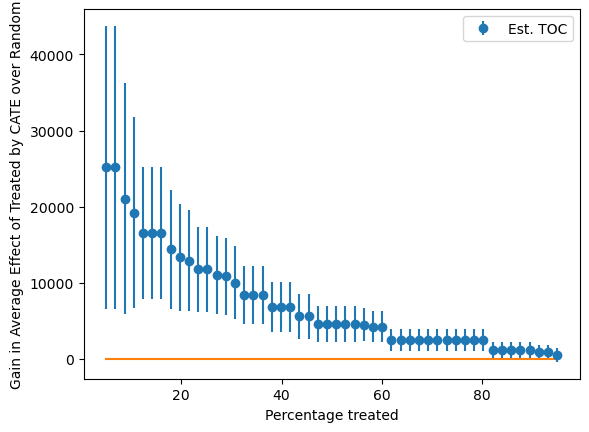

In [63]:
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value*toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

Note that if there is any point that is above the zero line, with confidence, in this curve, then the CATE model $\hat{\tau}$ has identified heterogeneity in the effect in a statistically significant manner. To do this we need a one-sided confidence interval, as we only care that the quantities are larger than some value with high confidence. We can then calculate the critical value for a uniform one-sided confidence interval across all the points, using the multiplier bootstrap. 

In [64]:
min_mboot = np.min(mboot, axis=0)
uniform_one_side_critical_value = np.abs(np.percentile(min_mboot, 5))
print(uniform_one_side_critical_value)

2.4358743065196586


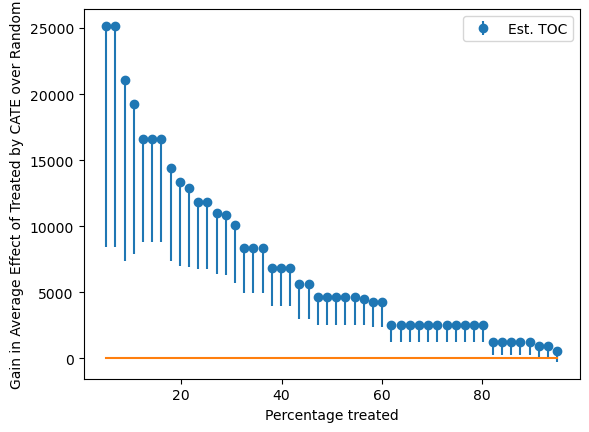

In [65]:
plt.errorbar(100 - ugrid, toc,
             yerr=[uniform_one_side_critical_value*toc_std, np.zeros(len(toc))], fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

In [66]:
print(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std)}')

Heterogeneity Statistic: 8767.458807340565


We can also calcualte the area under the curve and the confidence interval for that area. If the confidence interval does not contain zero, then we have again detected heterogeneity.

In [67]:
autoc_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(toc[:-1] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(f'AUTOC: {autoc:.4f}, s.e.: {autoc_stderr:.4f}, '
      f'One-Sided 95% CI=[{autoc - scipy.stats.norm.ppf(.95) * autoc_stderr:.4f}, Infty]')

AUTOC: 6254.7291, s.e.: 1067.9276, One-Sided 95% CI=[4498.1446, Infty]


### Qini Curve

Similar to the $\tau(q)$ curve, we can also consider a small variant of that curve that also incorporates the probability of treatment. So instead of looking just at the group average effect of the group of people that are prioritized by the CATE model and subtract the overall effect, we can look at the "total value" exctracted by the treated group and contrast it with the total value that would be extracted by an equally large group treated uniformly at random. This corresponds to:
\begin{align}
\tau_{\text{QINI}}(q) :=~& \tau(q)\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& \left(E[Y(1) - Y(0)\mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\right)\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& E\left[ (Y(1) - Y(0)) 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right] - E[Y(1) - Y(0)]\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& E\left[ (Y(1) - Y(0)) 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right] - E[Y(1) - Y(0)]\, E\left[1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right]\\
=~& \text{Cov}\left(Y(1) - Y(0), 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right)
\end{align}
The latter is approximately $\tau_{\text{QINI}}(q) \approx q \tau(q)$, but might not be exactly so, due to the inaccuracy of the quantile approximation $\hat{\mu}(q)$. 

The $\tau_{\text{QINI}}(q)$ quantity is identified by replacing the individual effects $Y(1)-Y(0)$ with the doubly robust pseudo-outcomes:
\begin{align}
\tau_{\text{QINI}}(q) := \text{Cov}\left(Y^{DR}(g,p), 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right)
\end{align}

Similarly, we can look at the area under this curve:
\begin{align}
\text{QINI} := \int_0^1 \tau_{\text{QINI}}(q) dq
\end{align}
which is known as the QINI coefficient. (standard errors here ignore cluster/group correlations)

In [68]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    toc[it] = group_prob * (np.mean(dr_test[inds]) - ate) # tau(q) = q * E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    toc_psi[it, :] = (dr_test - ate) * (inds - group_prob) - toc[it] # influence function for the tau(q)
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n) # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds - group_prob))

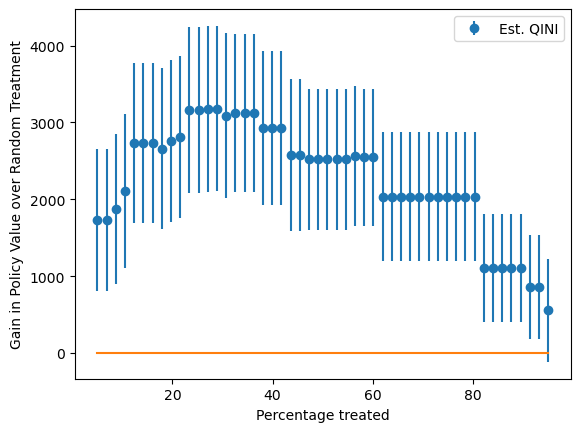

In [69]:
plt.errorbar(100 - ugrid, toc, yerr=1.96*toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over Random Treatment")
plt.legend()
plt.show()

And for uniform coverage we can again use the multiplier bootstrap

In [70]:
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (toc_psi / toc_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (toc_psi / toc_std.reshape(-1, 1)) @ w / n

max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)

2.6965853905432215


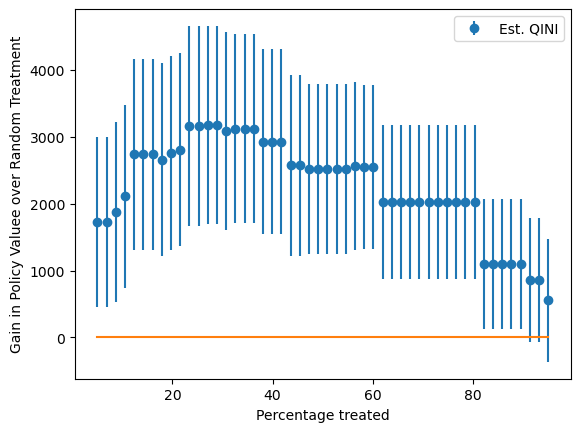

In [71]:
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value*toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Valuee over Random Treatment")
plt.legend()
plt.show()

Or the one-sided multiplier bootstrap

In [72]:
min_mboot = np.min(mboot, axis=0)
uniform_one_side_critical_value = np.abs(np.percentile(min_mboot, 5))
print(uniform_one_side_critical_value)

2.450381649627194


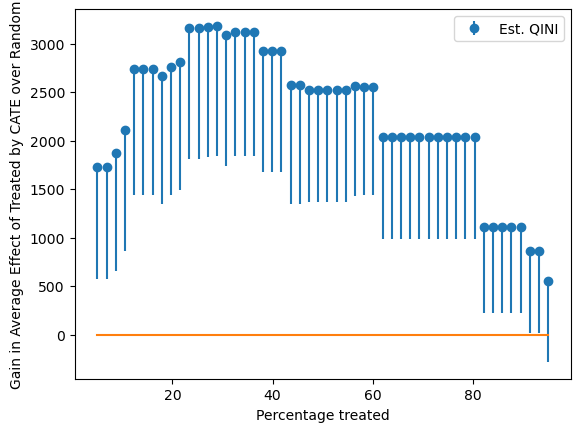

In [73]:
plt.errorbar(100 - ugrid, toc, yerr=[uniform_one_side_critical_value*toc_std, np.zeros(len(toc))],
             fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

In [74]:
print(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std)}')

Heterogeneity Statistic: 1838.1165907150696


In [75]:
qini_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(toc[:-1] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(f'QINI: {qini:.4f}, s.e.: {qini_stderr:.4f}, '
      f'One-Sided 95% CI=[{qini - scipy.stats.norm.ppf(.95) * qini_stderr:.4f}, Infty]')

QINI: 2050.2734, s.e.: 341.3060, One-Sided 95% CI=[1488.8750, Infty]


# Confidence Intervals on CATE Predictions

We now move on to the subject of constructing confidence intervals for the predictions of CATE models. Confidence intervals for CATE predictions is an inherently harder task. In its generality it is at least as hard as constructing confidence intervals for the predictions of a non-parametric regression function; which is a statistically daunting task. 

Two approaches help here:
- the first is to relax our goals and only go after the best linear approximation of the CATE on some pre-defined set of engineered features. This is the approach taken by the DRLearner with a linear final CATE model. We have already seen this approach earlier in this notebook and how we can even construct simultaneous (joint) confidence intervals for CATE parameters and for CATE predictions.
- the second is to use more data-adaptive approaches like random forests to side step the curse of dimensionality and potentially adapt to sparsity in the regression function (though theoretically such an adaptivity is in the worst case imposssible; it tends to work well in practice. This is the approach taken by CausalForests or Doubly Robust Forests that are both based on the idea of Generalized Random Forests, which is an extension of classical forests for solving problems defined via conditional moment restrictions.

# Confidence Intervals on BLPs of CATE with the DRLearner

In [76]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
if groups is None:
    lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='HC1')
else:
    lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='cluster', cov_kwds={'groups': groups})
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     11.31
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           0.000775
Time:                        20:38:56   Log-Likelihood:            -1.2518e+05
No. Observations:                9716   AIC:                         2.504e+05
Df Residuals:                    9714   BIC:                         2.504e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.971e+04   1.94e+04     -3.084      0.002   -9.77e+04   -2.18e+04
np.log(inc)  6533.4386   1942.965      3.363      0.001    2725.297    1.03e+04
==============================================================================
Omnibus:                     7328.777   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33693791.882
Skew:                          -1.952   Prob(JB):                         0.00
Kurtosis:                     291.468   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [77]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 110, 20)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)

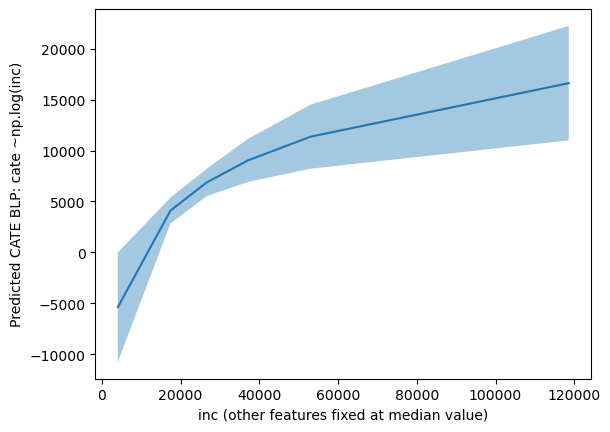

In [78]:
plt.plot(Xpd[xfeat], pred_df['mean'])
plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.ylabel('Predicted CATE BLP: cate ~' + blp_formula)
plt.show()

In [79]:
if semi_synth:
    df = X.copy()
    pred_df = lr.get_prediction(df).summary_frame(alpha=.1)
    df['cate'] = true_cate(X)
    lr = ols('cate ~ ' + blp_formula, df).fit()
    true_proj = lr.get_prediction(df).summary_frame(alpha=.1)['mean']
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], pred_df['mean'][inds])
    plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE BLP: cate ~' + blp_formula)
    plt.ylabel('Predicted CATE BLP: cate ~' + blp_formula)
    plt.show()

# Non-Parametric Confidence Intervals with Causal Forests

(standard errors here ignore cluster/group correlations)

In [80]:
from econml.grf import CausalForest

yres = y - res_preds
Dres = D - prop_preds
cf = CausalForest(4000, criterion='het', max_depth=5, max_samples=.4, min_samples_leaf=50, min_weight_fraction_leaf=.0)
cf.fit(Z, Dres, yres)

CausalForest(criterion='het', max_depth=5, max_samples=0.4, min_samples_leaf=50,
             n_estimators=4000)

In [81]:
top_feat = np.argsort(cf.feature_importances_)[-1]
print(Z.columns[top_feat])

inc


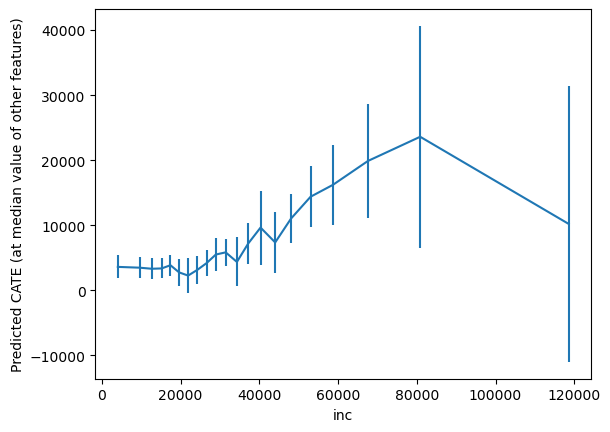

In [82]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                    columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [83]:
if semi_synth:
    true_proj = true_cate(X)
    preds, lb, ub = cf.predict(Z, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

# Non-Parametric Confidence Intervals with Doubly Robust Forests

(standard errors here ignore cluster/group correlations)

In [84]:
from econml.grf import RegressionForest

drrf = RegressionForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50,
                       min_weight_fraction_leaf=.0)
drrf.fit(Z, dr_preds)

RegressionForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
                 n_estimators=4000)

In [85]:
top_feat = np.argsort(drrf.feature_importances_)[-1]
print(Z.columns[top_feat])

inc


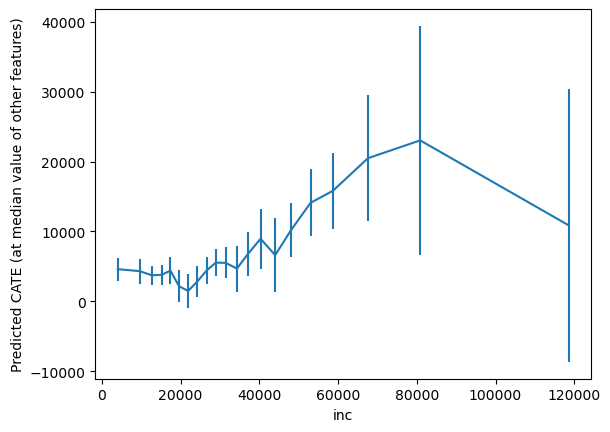

In [86]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                    columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [87]:
if semi_synth:
    true_proj = true_cate(X)
    preds, lb, ub = drrf.predict(Z, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

# Policy Learning

Suppose our goal is to estimate the best treatment policy $\pi: Z \to \{0, 1\}$. The policy gains over no treatment for any policy $\pi$ can be identified as:
\begin{align}
V(\pi) := E[\pi(Z)\, (Y(1) - Y(0))] = E\left[\pi(Z)\, Y^{DR}(g,p)\right]
\end{align}

Moreover, note that optimizing the linear objective $E[\pi(Z)\, Y^{DR}(g,p)]$ can also be written as a sample-weighted classification problem, where the goal of $\pi$ is to much the sign of $Y^{DR}(g,p)$, with sample weights $|Y^{DR}(g,p)|$.
\begin{align}
\text{argmin}_{\pi} V(\pi) =~& \text{argmin}_{\pi} E\left[(2\pi(Z) - 1)\, Y^{DR}(g,p)\right]\\
=~& \text{argmin}_{\pi} E\left[\left(2\pi(Z) - 1\right)\, \text{sign}\left(Y^{DR}(g,p)\right)\, \left|Y^{DR}(g,p)\right|\right] \\
=~& \text{argmin}_{\pi} E\left[1\left\{2\pi(Z) - 1 = \text{sign}\left(Y^{DR}(g,p)\right)\right\} \left|Y^{DR}(g,p)\right|\right] 
\end{align}

In [88]:
policy = DecisionTreeClassifier(max_depth=2, min_impurity_decrease=1e-3)
policy.fit(Z, np.sign(dr_preds), sample_weight=np.abs(dr_preds))

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.001)

We can also plot the tree to visualize the partitions and the treatment recommendations. The details that are displayed on each node are also useful in understanding the group average treatment effect for each node. In particular, the information `samples=N`, gives us the size of each node $N$, and the information `value=[A, B]`, then `A` is the sum of the $|Y^{DR}(g,p)|$ for the samples where $Y^{DR}(g,p)<0$ and similarly, `B` is the sum of $|Y^{DR}(g,p)|$ for the samples where $Y^{DR}(g,p)>0$. Thus to get the GATE for each node, we simply do `(B-A)/N`, which would correspond to $\frac{1}{N}\sum_{i\in \text{node}} Y^{DR}(g,p)$, which is the doubly robust estimate of the GATE for the node.

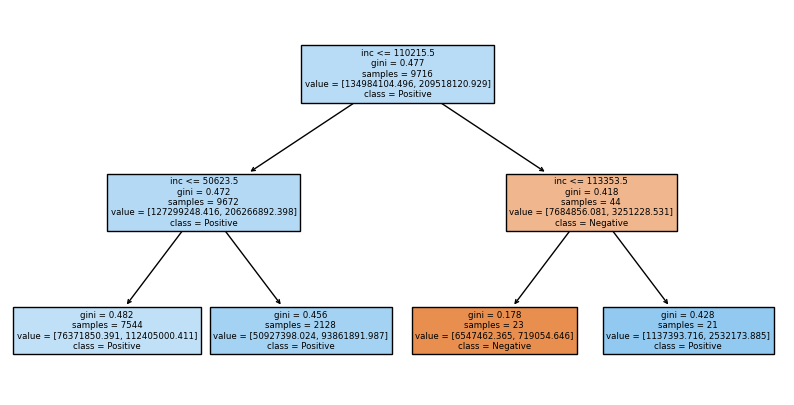

In [89]:
plt.figure(figsize=(10, 5))
plot_tree(policy, filled=True, feature_names=Z.columns,
          class_names=['Negative', 'Positive'])
plt.show()

We can also compare with the optimal tree policy if we had access to the true treatment CATE values for each sample.

In [90]:
true_cates = true_cate(X)
oracle_policy = DecisionTreeClassifier(max_depth=2, min_impurity_decrease=1e-3)
oracle_policy.fit(Z, np.sign(true_cates), sample_weight=np.abs(true_cates))

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.001)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\tree\_export.py:259: RuntimeWarning: invalid value encountered in divide
  node_val = tree.value[node_id][0, :] / tree.weighted_n_node_samples[node_id]


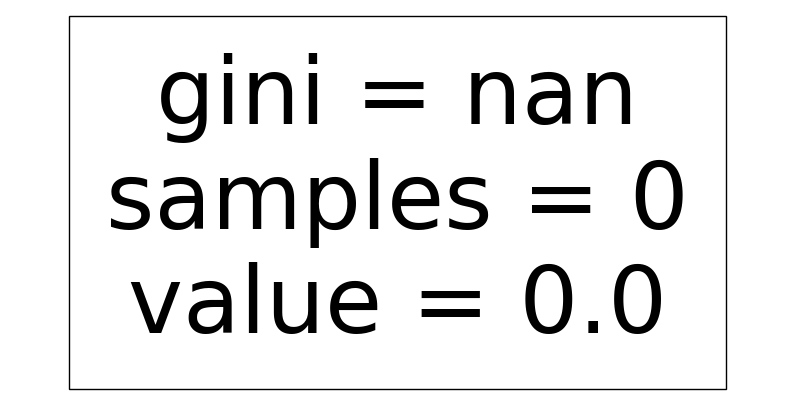

In [91]:
plt.figure(figsize=(10, 5))
plot_tree(oracle_policy, filled=True, feature_names=Z.columns)
plt.show()